In [320]:
library(iml)
library(randomForest)
library(mlr)
library(featureImportance)
options(warn=-1)

In [337]:
# Dataset used to predict chronic kidney disease
data<-read.table("kidney_disease.csv",sep=',',header=TRUE, stringsAsFactors = FALSE)
head(data)

id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48,80,1.020,1,0,,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,,normal,notpresent,notpresent,...,38,6000,,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,...,31,7500,,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd
5,60,90,1.015,3,0,,,notpresent,notpresent,...,39,7800,4.4,yes,yes,no,good,yes,no,ckd


## Data cleaning

In [230]:
data$classification[data$classification=='ckd\t']<-'ckd'

In [231]:
#data$cad
data$cad[data$cad=='\tno']<-'no'

In [232]:
df <- subset(data, select = -c(pot,sod,wc,rbc))

In [233]:
df[df == ""] <- NA

In [234]:
df=df[complete.cases(df), ]

In [235]:
dim(df)


[1] 210  22

In [236]:
apply(df,2,function(x) length(unique(x)))

id            age             bp             sg             al 
           210             63              7              5              5 
            su             pc            pcc             ba            bgr 
             6              2              2              2            103 
            bu             sc           hemo            pcv             rc 
            80             57             96             37             46 
           htn             dm            cad          appet             pe 
             2              2              2              2              2 
           ane classification 
             2              2

In [237]:
cols<-c('pc','pcc','ba','htn','dm','cad','appet','pe','ane')
for(i in cols){
  df[,i]=as.factor(df[,i])
}

#### Lets check the data set again
str(df)

'data.frame':	210 obs. of  22 variables:
 $ id            : int  0 3 4 8 9 11 12 14 15 18 ...
 $ age           : num  48 48 51 52 53 63 68 68 40 60 ...
 $ bp            : num  80 70 80 100 90 70 70 80 80 100 ...
 $ sg            : num  1.02 1 1.01 1.01 1.02 ...
 $ al            : num  1 4 2 3 2 3 3 3 3 0 ...
 $ su            : num  0 0 0 0 0 0 1 2 0 3 ...
 $ pc            : Factor w/ 2 levels "abnormal","normal": 2 1 2 1 1 1 2 1 2 2 ...
 $ pcc           : Factor w/ 2 levels "notpresent","present": 1 2 1 2 2 2 2 2 1 1 ...
 $ ba            : Factor w/ 2 levels "notpresent","present": 1 1 1 1 1 1 1 2 1 1 ...
 $ bgr           : num  121 117 106 138 70 380 208 157 76 263 ...
 $ bu            : num  36 56 26 60 107 60 72 90 162 27 ...
 $ sc            : num  1.2 3.8 1.4 1.9 7.2 2.7 2.1 4.1 9.6 1.3 ...
 $ hemo          : num  15.4 11.2 11.6 10.8 9.5 10.8 9.7 5.6 7.6 12.7 ...
 $ pcv           : chr  "44" "32" "35" "33" ...
 $ rc            : chr  "5.2" "3.9" "4.6" "4.0" ...
 $ htn           : 

In [238]:
cols2<-c('pcv','rc')
for(i in cols2){
  df[,i]=as.numeric(df[,i])
}


In [239]:
df=subset(df,select=-c(id))

In [240]:
X=subset(df,select=-c(classification))

In [300]:
# df$classification[df$classification=='ckd']<-0
# df$classification[df$classification=='notckd']<-1

# shuffle the dataset
df <- df[sample(nrow(df)),]
head(df)

,age,bp,sg,al,su,pc,pcc,ba,bgr,bu,...,hemo,pcv,rc,htn,dm,cad,appet,pe,ane,classification
389,51,80,1.02,0,0,normal,notpresent,notpresent,94,15,...,15.5,46,6.4,no,no,no,good,no,no,notckd
385,57,60,1.02,0,0,normal,notpresent,notpresent,132,18,...,15.4,42,4.5,no,no,no,good,no,no,notckd
249,59,70,1.01,1,3,abnormal,notpresent,notpresent,424,55,...,12.6,37,4.1,yes,yes,yes,good,no,no,ckd
208,50,70,1.01,0,0,normal,notpresent,notpresent,230,50,...,12.0,41,4.6,yes,yes,no,good,no,no,ckd
265,42,80,1.02,0,0,normal,notpresent,notpresent,132,24,...,14.4,50,4.5,no,no,no,good,no,no,notckd
243,69,70,1.01,4,3,abnormal,present,present,214,96,...,9.4,28,3.3,yes,yes,yes,good,yes,yes,ckd


In [72]:
#df['classification']=as.numeric(unlist(df['classification']))

In [294]:
# make the response column a factor
df$classification=as.factor(as.character(df$classification))

## Fit a random forest model
### Train a random forest classification model to predict kidney disease.

In [307]:
rf = randomForest(classification ~ ., data= df, ntree=70)
X = df[-which(names(df) == 'classification')]
y=df$classification
mod = Predictor$new(rf, data = X, y = y=='ckd',type='prob', class='ckd')

## Compute feature importances

Useful to note what features are relevant when it comes to the prediction values. Shuffle each feature and observe the change in predicted outputs. Use 'ce' for classification. From Metrics package : " ce is defined as the proportion of elements in actual that are not equal to the corresponding element in predicted. "

feature,importance.05,importance,importance.95,permutation.error
hemo,2.947368,3.210526,3.557895,0.5809524
pcv,2.678947,2.894737,2.989474,0.5238095
sc,2.642105,2.868421,3.221053,0.5190476
rc,2.605263,2.763158,3.131579,0.5000000
sg,2.047368,2.342105,2.694737,0.4238095


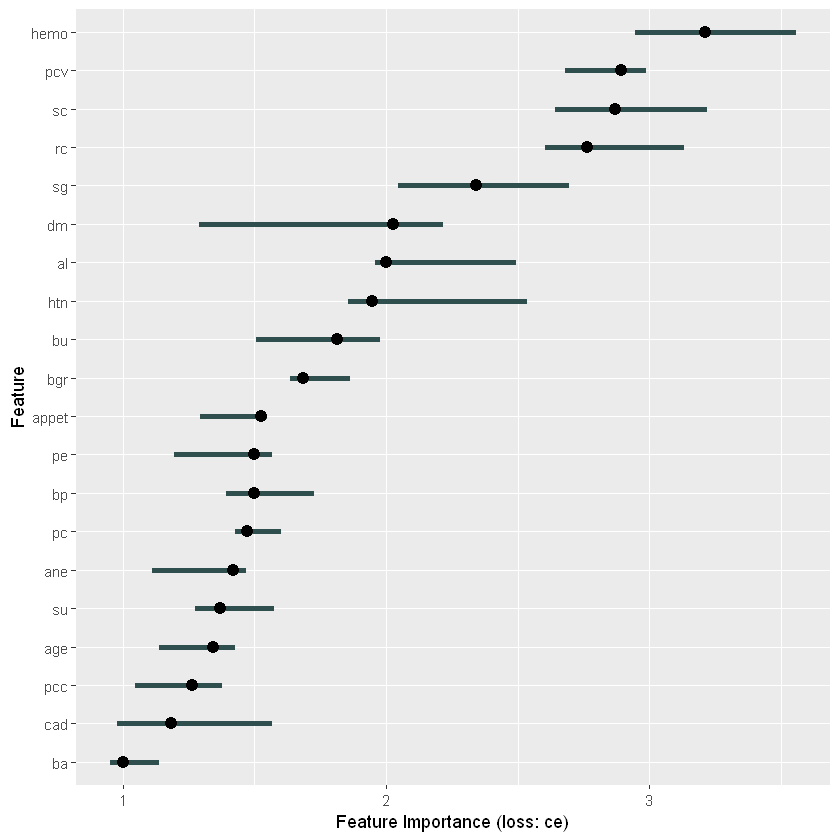

In [319]:
imp = FeatureImp$new(mod, loss = "ce")
imp$results[1:5,]
plot(imp)

The most important feature for predicting chronic kidney disease is the hemoglobin, with an error of 0.58 after permuting. Following closely are the features packed cell volume and serum creatinine.

## Partial Dependence Plot

A partial dependence plot shows how changing the values of a specific feature impacts the predicted outcome.
Each line represents the predictions for an individual of the dataset, for unique values of the hemoglobin feature. The PD plot is represented by the yellow line, that is the average of all individual prediction lines.

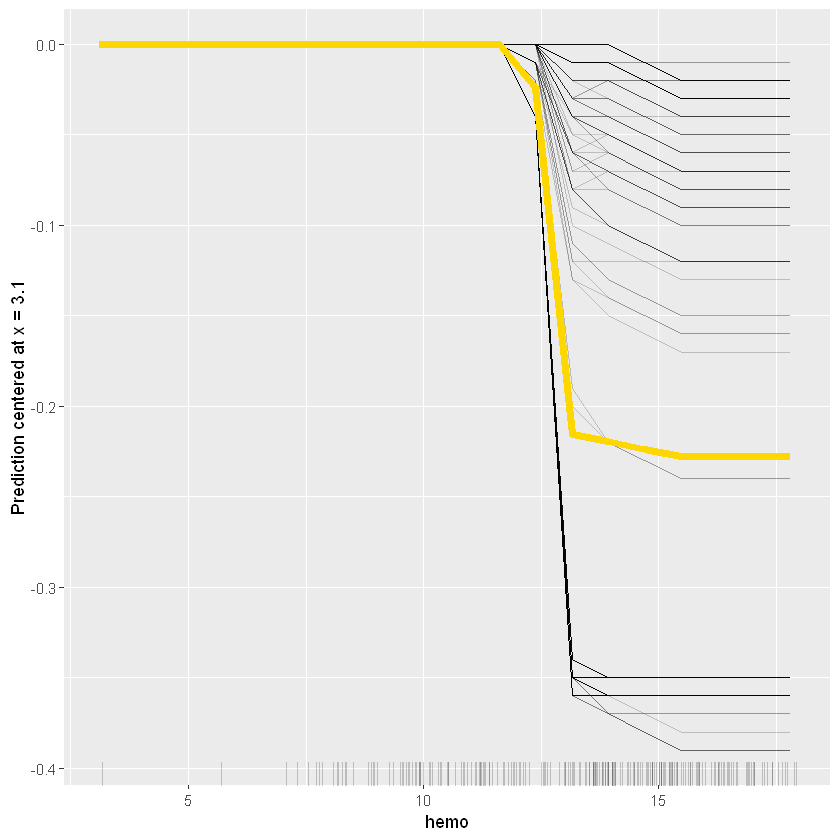

In [325]:
pdp.obj$set.feature("hemo")
pdp.obj$center(min(df$hemo))
plot(pdp.obj)

The plot above is a Centered ICE plot of kidney disease probability by hemoglobin. It centers all prediction lines to the minimum value of the feature, for an easier interpretation.
The y-axis shows the survival probability difference to hemo = 3.1. 
Compared to hemo = 3.1, the predictions for most individuals decrease as values of hemo increase. There is a sharp drop around hemo = 12.5.

## Explaining predictions with Shapely values

,age,bp,sg,al,su,pc,pcc,ba,bgr,bu,...,hemo,pcv,rc,htn,dm,cad,appet,pe,ane,classification
49,73,70,1.005,0,0,normal,notpresent,notpresent,70,32,...,10,29,3.5,yes,yes,no,good,yes,no,ckd


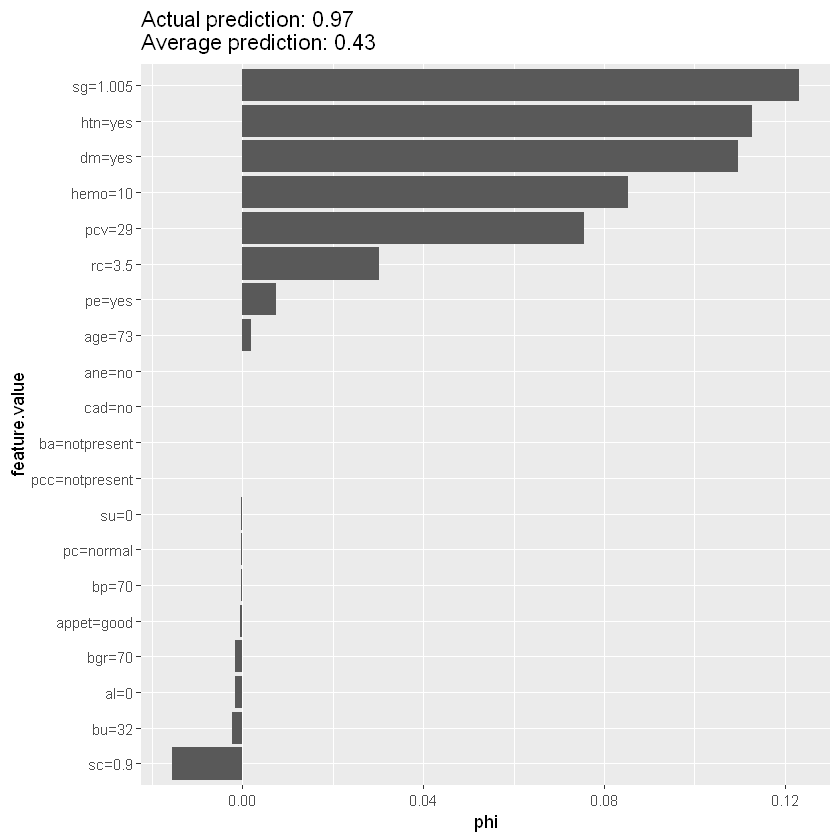

In [342]:
df[29,]
shapley = Shapley$new(mod, x.interest = X[29,])
plot(shapley)

Shapley values for an individual: With a predicted output of 0.97, this individual's probability of having chronic kidney disease is 0.54 above the average prediction of 0.43. The sg (specific gravity) of 1.005 increased the probability the most. The sum of contributions yields the difference between actual and average prediction (0.54).

,age,bp,sg,al,su,pc,pcc,ba,bgr,bu,...,hemo,pcv,rc,htn,dm,cad,appet,pe,ane,classification
321,57,60,1.02,0,0,normal,notpresent,notpresent,105,49,...,15.7,44,6.2,no,no,no,good,no,no,notckd


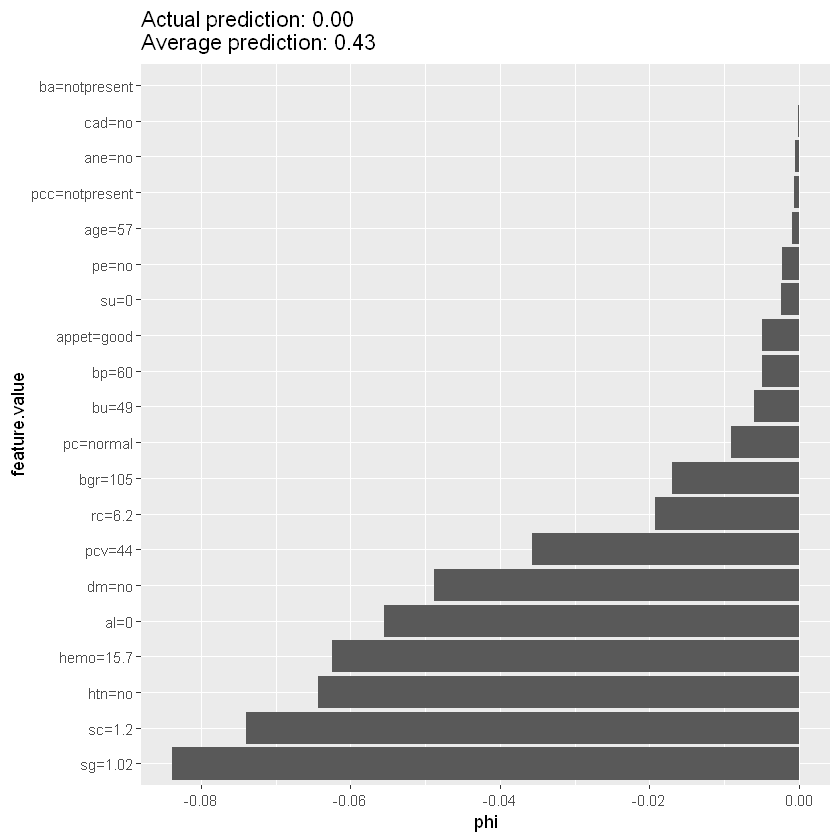

In [343]:
df[98,]
shapley = Shapley$new(mod, x.interest = X[98,])
plot(shapley)

This individual's probability of having kidney disease is 0, below the average of 0.43. The sg of 1.02 and hemoglobin of 15.7 had the largest negative contributions to the predicted outcome. 

## Explaining predictions with LIME 

In order to explain an individual prediction using LIME (Local interpretable model-agnostic explanations), we fit a simpler model, giving higher weights to data points closer to the subject of interest.

In the next examples, 5 features are used to build the explanations.
The two individuals chosen have different predicted classes.

,beta,x.recoded,effect,x.original,feature,feature.value
sg,-13.18885987,1.005,-13.25480417,1.005,sg,sg=1.005
hemo,-0.02499673,10.000,-0.24996726,10,hemo,hemo=10
pcv,-0.00419018,29.000,-0.12151523,29,pcv,pcv=29
htn=yes,0.23382759,1.000,0.23382759,yes,htn=yes,htn=yes
dm=yes,0.07720458,1.000,0.07720458,yes,dm=yes,dm=yes


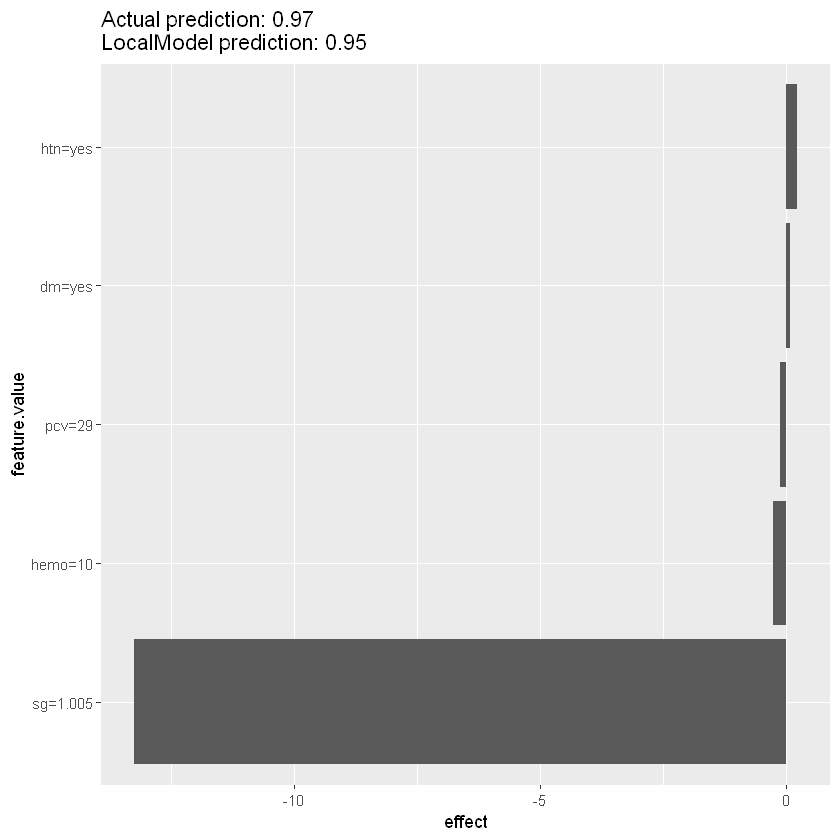

In [310]:
lime.explain = LocalModel$new(mod, x.interest = X[29,],k=5)
lime.explain$results
plot(lime.explain)

The value of 1.005 of the sg(specific gravity) feature has the highest negative effect on the output. The other features have almost insignificant effects in comparison. The feature effect is computed as the weight x the observed feature value.

,beta,x.recoded,effect,x.original,feature,feature.value
sg,-11.549475119,1.025,-11.83821200,1.025,sg,sg=1.025
hemo,-0.022493303,14.900,-0.33515022,14.9,hemo,hemo=14.9
pcv,-0.003540765,41.000,-0.14517135,41,pcv,pcv=41
htn=no,-0.208461676,1.000,-0.20846168,no,htn=no,htn=no
dm=no,-0.034911764,1.000,-0.03491176,no,dm=no,dm=no


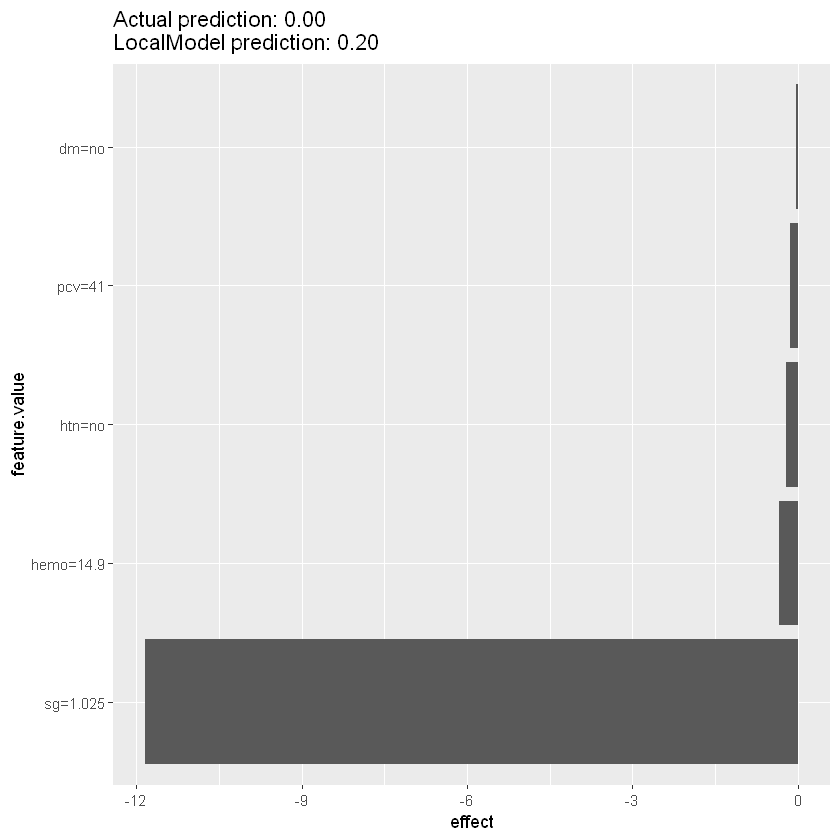

In [336]:
lime.explain$explain(X[89,])
lime.explain$results
plot(lime.explain)